In [1]:
import matplotlib.pyplot as plt

from utilities.utils import load_patterns, generate_patterns, show_tiles
from wfc.cell_image import TileImage
from wfc.wfc import WFC

import os.path as osp

# <center>**Simple Tile Model**</center>
This is the Wave Function Collapse demonstration for predefined tiles.\
The constraint here is that adjacent tiles must have the same border.

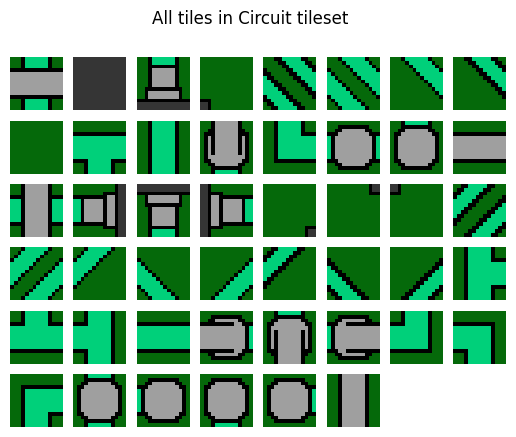

In [2]:
tileset_name = 'Circuit'
tile_folder = osp.join('..', 'images', 'tilesets', tileset_name)
patterns = load_patterns(tile_folder)


fig, axes = show_tiles(patterns)
fig.suptitle(f'All tiles in {tileset_name} tileset')
pass

Wave Function Collapse using the tileset loaded

In [3]:
dim = (10, 30)
tiles = [TileImage(pattern, 1) for pattern in patterns]
wfc = WFC(dim, tiles)
result = wfc.run()
print(f"All cells collapsed: {result[0]}")

All cells collapsed: True


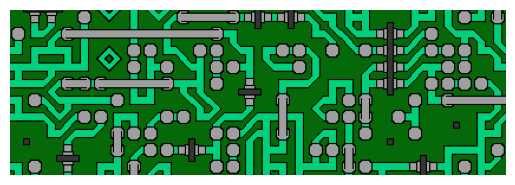

In [4]:
plt.imshow(result[1])
plt.axis('off')
pass

# <center>**Overlapping Model**</center>
Demonstration of generating patterns and adjacency rules from a sample image

Extracted 92 tiles


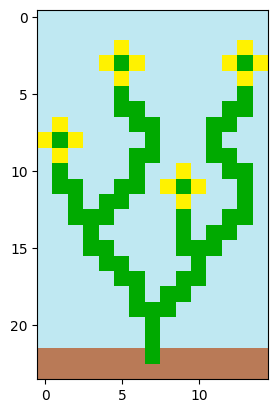

In [4]:
fname = osp.join('..', 'images', 'tileset_generator', 'Flowers.png')
plt.imshow(plt.imread(fname))

patterns = generate_patterns(fname)
print(f"Extracted {len(patterns)} tiles")

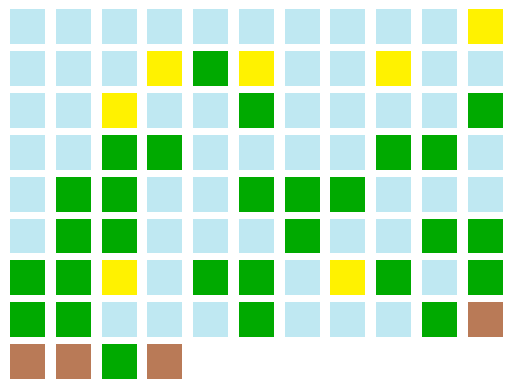

In [5]:
show_tiles([tile.image for tile in patterns])
pass

In [6]:
# reusing the wfc class, just with different patterns
wfc.patterns = patterns
result = wfc.run()
print(f"All cells collapsed: {result[0]}")

All cells collapsed: True


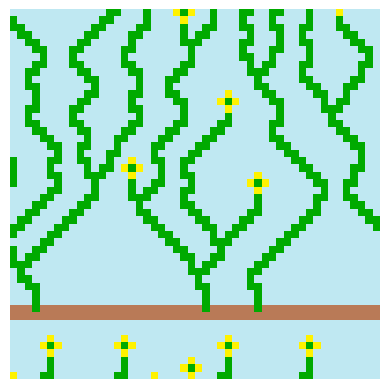

In [7]:
plt.imshow(result[1])
plt.axis('off')
pass

# <center>**Custom Constraints**</center>
There's one thing to notice about the Circuit demo. The skews could not connect to any track, this is
because their border has one pixel off from the track.\
Hence, I made a new_skew and new_dskew pattern
just for them to be able to satisfy the default border constraint.\
However, the new patterns can look weird in the tilemap.
More importantly, it's not very flexible for designing purpose having to take this border constraint in mind.

To fix this, we can add additional constraint instead of correcting the pattern.\
For example, we add the constraint that say skew and d_skew can connect to the right of a track, or above a track, and so on,...

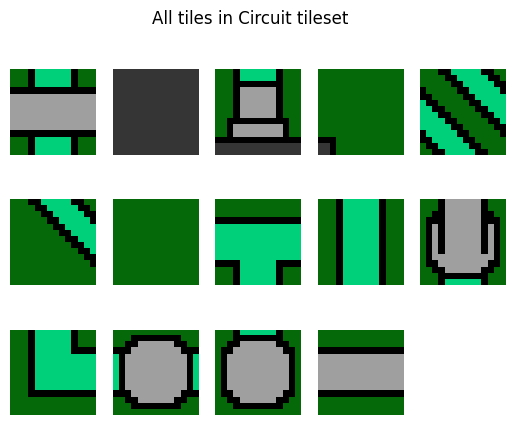

In [8]:
tileset_name = 'Circuit'
tile_folder = osp.join('..', 'images', 'tilesets', tileset_name)
patterns = load_patterns(tile_folder, rotate=False)

#removing the new skew pattern
patterns = patterns[:5] + patterns[7:]

fig, axes = show_tiles(patterns)
fig.suptitle(f'All tiles in {tileset_name} tileset')
pass

In [9]:
from scipy.ndimage import rotate
import numpy as np

# encoding the patterns for constraint checking
# the numebrs represent the index of each unique border
# this should be read in the clockwise direction
encoded_patterns = [np.array([[0, 1], [1, 0]]),
                    np.array([[2, 2], [2, 2]]),
                    np.array([[0, 3], [3, 2]]),
                    np.array([[4, 4], [3, 3]]),
                    np.array([[0, 0], [0, 0]]),
                    np.array([[0, 0], [4, 4]]),
                    np.array([[4, 4], [4, 4]]),
                    np.array([[4, 0], [0, 0]]),
                    np.array([[0, 4], [4, 0]]),
                    np.array([[1, 4], [4, 0]]),
                    np.array([[0, 0], [4, 4]]),
                    np.array([[4, 0], [0, 4]]),
                    np.array([[0, 4], [4, 4]]),
                    np.array([[4, 1], [1, 4]])]

# rotating the patterns to generate new patterns
extras = []
for i, pattern in enumerate(patterns):
    ninety = rotate(pattern, 90)
    if (ninety == pattern).all(): continue

    eighty = rotate(pattern, 180)
    twensev = rotate(pattern, 270)

    extras.append(ninety)
    encoded_patterns.append(rotate(encoded_patterns[i], 90))
    
    if not (eighty == pattern).all():
        extras.append(eighty)
        encoded_patterns.append(rotate(encoded_patterns[i], 180))
    if not (ninety == twensev).all():
        extras.append(twensev)
        encoded_patterns.append(rotate(encoded_patterns[i], 270))
patterns.extend(extras)

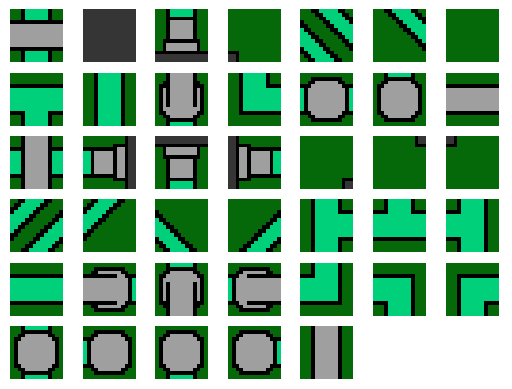

In [10]:
show_tiles(patterns)
pass

In [11]:
from wfc.cell_image import Direction

class CustomTile(TileImage):
    __slots__="index"
    # This class now receives an additional index of the tile
    def __init__(self, index, pattern, frequency):
        super().__init__(pattern, frequency)

        self.index = index

    # adding a custom constraint check
    def is_adjacent_to(self, tile: 'CustomTile', direction: Direction) -> bool:
        # only the skew patterns need a different check, that is tiles with indices 4, 5, 21-24
        # the rest can be checked with the default constraint
        if not ((tile.index in [4, 5, 21, 22, 23, 24]) or (self.index in [4, 5, 21, 22, 23, 24])):
            return super().is_adjacent_to(tile, direction)
        match direction:
            case Direction.UP:
                return encoded_patterns[self.index][1, 1] == encoded_patterns[tile.index][0, 0]
            case Direction.DOWN:
                return encoded_patterns[self.index][0, 0] == encoded_patterns[tile.index][1, 1]
            case Direction.LEFT:
                return encoded_patterns[self.index][0, 1] == encoded_patterns[tile.index][1, 0]
            case Direction.RIGHT:
                return encoded_patterns[self.index][1, 0] == encoded_patterns[tile.index][0, 1]

(np.float64(-0.5), np.float64(419.5), np.float64(139.5), np.float64(-0.5))

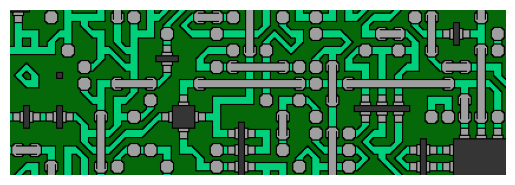

In [45]:
wfc.patterns = [CustomTile(i, pattern, 1) for i, pattern in enumerate(patterns)]
result = wfc.run()
plt.imshow(result[1])
plt.axis('off')